In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [5]:
df = pd.read_csv('COUNTRY-BORDERS.csv')
df.head()

,country_code,country_name,country_border_code,country_border_name
0,AD,Andorra,FR,France
1,AD,Andorra,ES,Spain
2,AE,United Arab Emirates,OM,Oman
3,AE,United Arab Emirates,SA,Saudi Arabia
4,AF,Afghanistan,CN,China


In [4]:
df.nunique()

country_code           248
country_name           249
country_border_code    162
country_border_name    163
dtype: int64

In [77]:
# Object Creation
GR = nx.Graph()

vrtxs = df.country_code.unique()
edges = df.dropna().pipe(lambda _df: _df.assign(edges = list(zip(_df['country_code'], _df['country_border_code']))) ).edges.to_list()

GR.add_nodes_from(vrtxs)
GR.add_edges_from(edges)

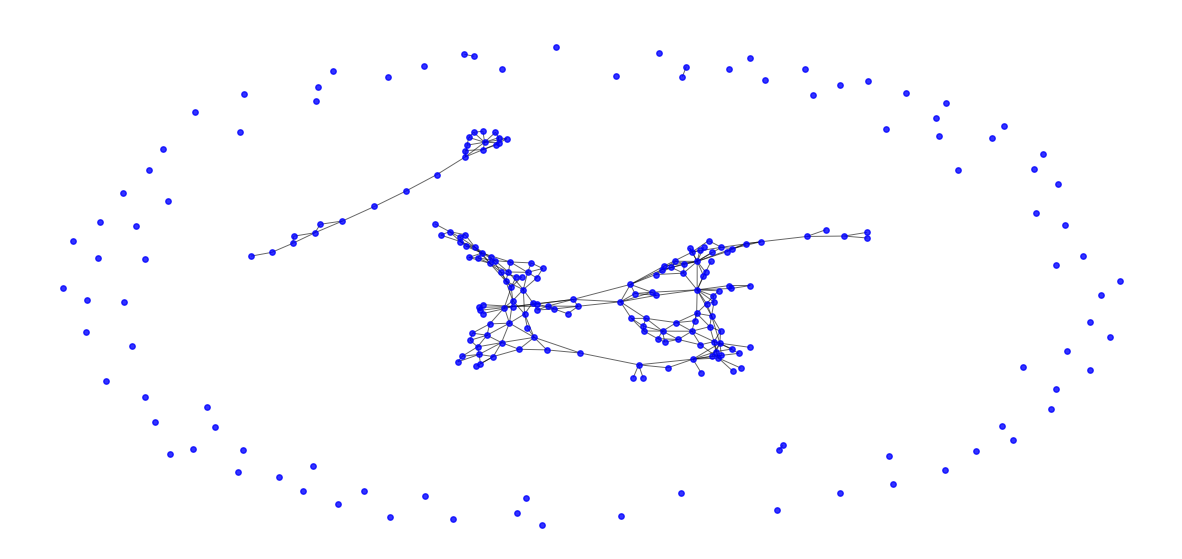

In [84]:
plt.figure(figsize=(15,7))

# Circular Layout
#pos = nx.circular_layout(GR)
#pos = nx.kamada_kawai_layout(GR) #great

pos = nx.spring_layout(GR)

# Draw nodes 
nx.draw_networkx_nodes(GR, pos, node_size=15, node_color='blue', alpha=0.8, label=vrtxs)
# Draw edges
nx.draw_networkx_edges(GR, pos, width=0.7, alpha=0.6)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

Centrality

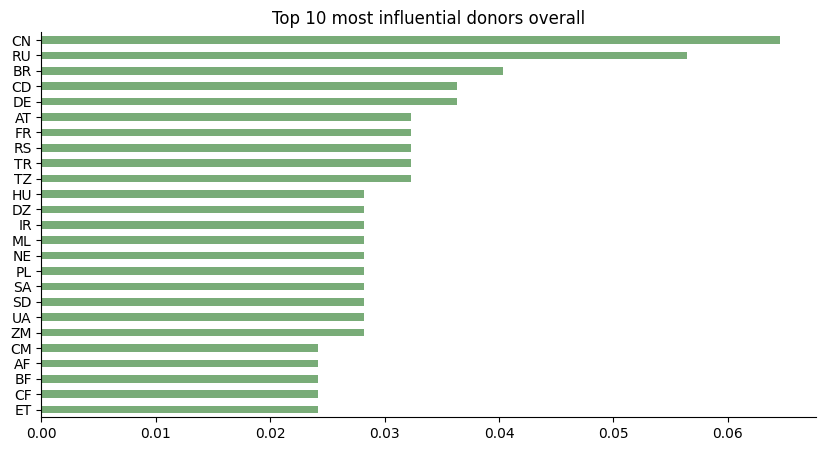

In [89]:
topBorders = pd.Series( nx.degree_centrality(GR) )

topBorders.nlargest(25).sort_values(ascending=True).plot.barh(figsize=(10,5), title='Top 10 most influential donors overall', color=['#79AC78'])

sns.despine(top=True, right=True)
plt.show()